# Comparing GRU and LSTM with Stock data

In [93]:
#!pip install yfinance

import sys
print(sys.executable)

# numpy 설치했음에도 에러가 날때
sys.path.append('C:\\Users\\ample\\miniconda3\\envs\\tensorflow\\lib\\site-packages')
sys.path.append('C:\\Users\\ample\\miniconda3\\envs\\tensorflow')
sys.path.append('C:\\Users\\ample\\miniconda3\\envs\\tensorflow\\lib')       
sys.path.append('C:\\Users\\ample\\miniconda3\\envs\\tensorflow\\DLLs')        
sys.path.append('C:\\Users\\ample\\miniconda3\\envs\\tensorflow\\python37.zip')


import numpy as np
import pandas as pd 


import yfinance as yf # Yahoo finance 에서 제공하는 데이터에 접근 가능

C:\Users\ample\miniconda3\python.exe


In [97]:
import sqlite3

conn = sqlite3.connect("D:\\Dev\\CSharp\\DBmakerForDeeplearn\\DBmakerForDeeplearn\\bin\\Debug\\DB\\GijoonForKeras.db")
cur = conn.cursor()

cur.execute("SELECT * FROM gijoon WHERE id<100") 
             
rows = cur.fetchall()

df = pd.DataFrame(rows, columns=['id', 'code', 'name', 'date', 'endprice', 'updown', 'compare', 'volume', 'totalmoney', 'startprice', 'highprice', 'lowprice', 'mkcap', 'shares', 'ratio_start', 'ratio_high', 'ratio_low', 'ratio_end'])

print(df[0:5])
print(df.shape)
    
conn.close()


   id    code  name        date  endprice  updown  compare  volume  \
0   0  041140  넥슨지티  2018-12-17      6670       0        0  107077   
1   0  041140  넥슨지티  2018-12-18      6400       0        0  221561   
2   0  041140  넥슨지티  2018-12-19      6420       0        0   71970   
3   0  041140  넥슨지티  2018-12-20      6200       0        0  169073   
4   0  041140  넥슨지티  2018-12-21      6570       0        0  219149   

   totalmoney  startprice  highprice  lowprice  mkcap  shares  ratio_start  \
0   717829310        6720       6800      6650      0       0        -0.74   
1  1432389880        6590       6610      6380      0       0        -1.20   
2   461318390        6360       6480      6350      0       0        -0.63   
3  1050639810        6350       6400      6120      0       0        -1.09   
4  1406672180        6150       6650      6150      0       0        -0.81   

   ratio_high  ratio_low  ratio_end  
0        0.44      -1.77      -1.48  
1       -0.90      -4.35      -4.0

(5503, 6)
<class 'pandas.core.frame.DataFrame'>


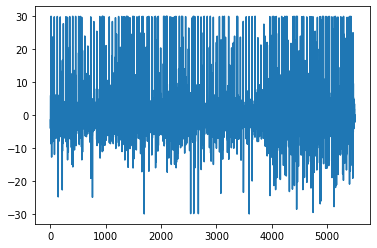

In [137]:

all_data = df[['id', 'ratio_start', 'ratio_high', 'ratio_low', 'ratio_end', 'totalmoney']]

FEATURES = all_data.shape[1] - 1 # id 열 제외할거기 때문에 1 빼줌

all_data.head(15)

all_data['ratio_end'].plot()

print(all_data.shape)

print(type(all_data))

In [138]:
all_data.head(15)

,id,ratio_start,ratio_high,ratio_low,ratio_end,totalmoney
0,0,-0.74,0.44,-1.77,-1.48,717829310
1,0,-1.20,-0.90,-4.35,-4.05,1432389880
2,0,-0.63,1.25,-0.78,0.31,461318390
3,0,-1.09,-0.31,-4.67,-3.43,1050639810
4,0,-0.81,7.26,-0.81,5.97,1406672180
5,0,-1.37,3.35,-2.44,0.61,1383244450
6,0,-3.18,-1.36,-4.69,-3.93,816762500
7,0,0.94,6.30,0.79,1.89,726211170
8,0,0.77,2.78,0.62,1.08,422341330
9,0,1.83,1.83,-3.06,-2.60,549846500


In [139]:
TIME_STEPS = 7
FOR_PERIODS = 1

In [140]:
def Make_LSTM_model():
    # create a model. LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 50, 
                           return_sequences = True, 
                           input_shape = (TIME_STEPS, FEATURES),  # (timestep, feature)
                           activation = 'tanh'))
    my_LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
    my_LSTM_model.add(Dense(units=5))
    
    # Compiling 
    my_LSTM_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False),
                         loss = 'mean_squared_error')
    return my_LSTM_model 

my_LSTM_model = Make_LSTM_model()

C:\Users\ample\miniconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:106: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [141]:

from sklearn.preprocessing import MinMaxScaler 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM
from tensorflow.keras.optimizers import SGD

# 모듈로 구분하기, scale / train 
# 학습, 테스트 데이터 구분하기

# 스케일 하고 부분 시퀀스로 나눔
def ts_train_test_normalize(all_data__, time_steps, for_periods):
    # 몇종목은 학습 데이터로, 나머지 종목은 테스트 데이터로
    # 그래서 일단은 학습 데이터만 만들자
    
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(all_data__) # fit 은 표준편차 구하는거고, transform 은 구한걸로 변환 # train 데이터로 fit해서 test를 변환
    
    #print(ts_train_scaled[0:15])
    
    ts_train_len = len(all_data__)
    # create training data of s samples and t time steps 
    X_train = [] 
    y_train = [] 
    for i in range(time_steps, ts_train_len-1):  # 종가를 타임스텝5로 잘라 배열하는듯. range(n, m) n 부터 m까지
        #print('i : ' + str(i))
        #print(ts_train_scaled[i-time_steps:i])
        X_train.append(ts_train_scaled[i-time_steps:i]) # 종가 5개
        y_train.append(ts_train_scaled[i:i+for_periods]) # 결과 for_periods개 
    X_train, y_train = np.array(X_train), np.array(y_train)
    #X_train_3d = X_train.reshape(X_train.shape[0], time_steps, FEATURES)
    
    return X_train, y_train , sc 

In [142]:
def ScaleDataAndFitModel(jongData):

    X_train, y_train, sc = ts_train_test_normalize(jongData, TIME_STEPS, FOR_PERIODS)
    print(X_train.shape)
     
    # Fitting to the training set 
    my_LSTM_model.fit(X_train, y_train, epochs = 50, batch_size = 150, verbose = 0)
    
    # print(X_train[0:5])
    # 원래 예제 다시보기 feature가 1개다. 내 경우는 5개로 조정
    #print('X_train.shape: ' + ", ".join(map(str,X_train.shape))) # (210, 7, 5) # 데이터, 시퀀스 길이, 피쳐
    #print('y_train.shape: ' + ", ".join(map(str,y_train.shape))) # (210, 1, 5)

    
def GetDataByIndex(index):
    return all_data[all_data['id'] == index].iloc[:,1:]


In [143]:

for i in range(10):  # range(n) [0...n-1]
    print(i)
    part = GetDataByIndex(i)
    ScaleDataAndFitModel(part)


0
(43, 7, 5)
1
(44, 7, 5)
2
(46, 7, 5)
3
(48, 7, 5)
4
(47, 7, 5)
5
(49, 7, 5)
6
(47, 7, 5)
7
(48, 7, 5)
8
(47, 7, 5)
9
(46, 7, 5)


In [156]:
orig = GetDataByIndex(3)
X_test ,_ ,_ = ts_train_test_normalize(orig, TIME_STEPS, FOR_PERIODS)

print(orig[0:15])
print("------")
print(X_test[0:15])


LSTM_prediction = my_LSTM_model.predict(X_test)

LSTM_prediction = sc.inverse_transform(LSTM_prediction)

print('=================')
print('LSTM_prediction: ' + ", ".join(map(str,LSTM_prediction.shape)))
#print(LSTM_prediction[0:30]) 

np.set_printoptions(formatter={'float_kind': lambda x: "{0:0.2f}".format(x)})
result = np.round(LSTM_prediction, 2)

dd = result[0:5]

for data in dd:
    print(data)
    #print("{0:0.2f}".format(cell))


     ratio_start  ratio_high  ratio_low  ratio_end   totalmoney
157         2.48        7.99       1.65       6.06  45069644650
158        -2.08        0.78      -3.90      -2.86  22118295750
159         0.00        1.34      -3.48      -2.41  13912632150
160         1.64        2.74      -0.55      -0.27  10469677950
161        -0.27        1.92      -2.75      -1.65   9299735650
162         1.12        3.91       0.84       3.07   8572473050
163         0.27        0.27      -2.71      -1.08   9164440900
164        -0.27       -0.27      -3.84      -3.01  11209407850
165         0.00        0.85      -3.67      -2.54  10736147200
166         0.00        3.19      -1.16       2.03   7253724400
167         2.56        4.83       0.57       2.27  14220427900
168         0.83        1.39      -2.78      -1.94   7001288900
169         1.70        7.65       1.13       6.23  39003961250
170         0.80       10.93      -0.27       3.73  72157979100
171         4.37       10.54       2.31 

In [66]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

def confirm_result(y_test, y_pred):
    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    MSLE = mean_squared_log_error(y_test, y_pred)
    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred))
    R2 = r2_score(y_test, y_pred)
    
    pd.options.display.float_format = '{:.5f}'.format
    Result = pd.DataFrame(data=[MAE,RMSE, RMSLE, R2],
                         index = ['MAE','RMSE', 'RMSLE', 'R2'],
                         columns=['Results'])
    return Result

In [12]:
confirm_result(y_test, y_pred)

,Results
MAE,39.01289
RMSE,48.22952
RMSLE,0.02685
R2,0.77401
